# Goal 2 - Get insights about stories that are similar to users topic.


Get insights about stories that are similar to users topic - Identifying the class of the new story will be performed by CNN algorithm.


In [1]:
import numpy as np 
import pandas as pd 
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout, concatenate
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Reading CSV data file

In [2]:
df = pd.read_csv("Medium_AggregatedData.csv")

In [3]:
#Columns in dataframe
df.columns

Index(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount', 'subTitle',
       'tagsCount', 'text', 'title', 'totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'],
      dtype='object')

In [4]:
#Calculating length of the text 
df['textLen'] = df['text'].str.len()

In [5]:
print(df.shape[0], 'total sentences')

279577 total sentences


# Dropping columns which are not required

In [6]:
df.drop(columns=['audioVersionDurationSec', 'codeBlock', 'codeBlockCount', 'collectionId', 'createdDate', 
                 'createdDatetime', 'firstPublishedDate','firstPublishedDatetime','imageCount', 'isSubscriptionLocked',
                 'latestPublishedDate', 'latestPublishedDatetime', 'linksCount', 'responsesCreatedCount', 
                 'socialRecommendsCount','uniqueSlug', 'updatedDate', 'updatedDatetime', 'url', 'vote',
                 'publicationdomain','publicationfacebookPageName', 'publicationdescription',
                 'publicationfollowerCount','publicationname', 'publicationpublicEmail', 'publicationslug',
                 'publicationtags', 'publicationtwitterUsername','slug','name', 'postCount',
                 'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'], inplace=True)

In [7]:
df.head()

,language,postId,readingTime,recommends,subTitle,tagsCount,text,title,totalClapCount,wordCount,tag_name,author,bio,userId,userName,textLen
0,en,10007d3018fe,0.958491,2,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,201,Blockchain,Anar Babaev,NaN,f1ad85af0169,babaevanar,1244
1,en,10007d3018fe,0.958491,2,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,201,Samsung,Anar Babaev,NaN,f1ad85af0169,babaevanar,1244
2,en,10007d3018fe,0.958491,2,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,201,It,Anar Babaev,NaN,f1ad85af0169,babaevanar,1244
3,en,1000c43bcb97,19.716981,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,4854,Technology,George Sykes,NaN,93b9e94f08ca,tasty231,30073
4,en,1000c43bcb97,19.716981,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,4854,Robotics,George Sykes,NaN,93b9e94f08ca,tasty231,30073


# Calculating Z-Score for total Claps

In [8]:

outlierCutoff = np.percentile(df['totalClapCount'], 90)
cVector = np.clip(df['totalClapCount'], 0, outlierCutoff)

medianScore = np.median(cVector)

stdScore = df['totalClapCount'].std()

print(outlierCutoff, medianScore, stdScore)
zScore = ((cVector - medianScore) / stdScore)
print("Z Score: ", zScore.head())

df['totalClapCount'] = cVector
df['clap_zscore'] = zScore



263.0 8.0 1985.3530039583984
Z Score:  0    0.046339
1    0.046339
2    0.046339
3   -0.004030
4   -0.004030
Name: totalClapCount, dtype: float64


# Splitting dataset into train and test set

In [9]:
train, test = train_test_split(df, random_state = 2019, test_size = 0.25, stratify = pd.qcut(cVector.values, 10, duplicates = 'drop'))

print('train sentences', train.shape[0], 'test sentences', test.shape[0])
train.sample(5)

train sentences 209682 test sentences 69895


,language,postId,readingTime,recommends,subTitle,tagsCount,text,title,totalClapCount,wordCount,tag_name,author,bio,userId,userName,textLen,clap_zscore
198641,en,e19dea997312,3.361321,36,What The Foundation can teach us.,5,"Sci-Fi, AI and Leadership\nFrom io9\nThe Found...","Sci-Fi, AI and Leadership",263.0,745,Leadership,Danilo Pena,Life | Random Thoughts | Data Science | Health...,72469f5805d8,danilopena,4243,0.128441
125852,en,954edfd20fa8,3.523899,26,"As every year, we’ve asked eCommerce Managers ...",5,eCommerce Trends 2018 (backed by real data)\nA...,eCommerce Trends 2018 (backed by real data),97.0,713,Startup,Tom Karwatka,CEO @DivanteLTD — eCommerce Software House,5ad461902d03,tomik99,4374,0.044828
203137,en,e63920f53144,13.934906,12,How perverse incentives have the potential to ...,5,Product Management Ethics In The Age Of Artifi...,Product Management Ethics In The Age Of Artifi...,85.0,3176,Ethics,Drew Dillon,Chief Product Officer at Skedulo,24df326d313e,drewdil,18734,0.038784
93407,en,7328930d649e,2.739623,0,So I have been reading a lot of stuff on data ...,3,Understanding the k nearest neighbors\nSo I ha...,Understanding the k nearest neighbors,0.0,726,Machine Learning,Shikhar Srivastava,NaN,511718278c6f,shikhar022,3995,-0.004030
187357,en,d5d5330443f3,3.611321,0,NaN,3,"HubSpot Acquires Motion AI, Hires Scott Brinke...","HubSpot Acquires Motion AI, Hires Scott Brinke...",0.0,904,Marketing,MarTech Advisor,Helping Marketers Succeed,4a1305dc5a36,martechadvisor,5685,-0.004030


In [10]:
# defining network parameters
maxFeatures = 30000
maxLen = 150
textField = 'text'

In [11]:
listSentencesTrain = train[textField].fillna("Invalid").values
listSentencesTest = test[textField].fillna("Invalid").values

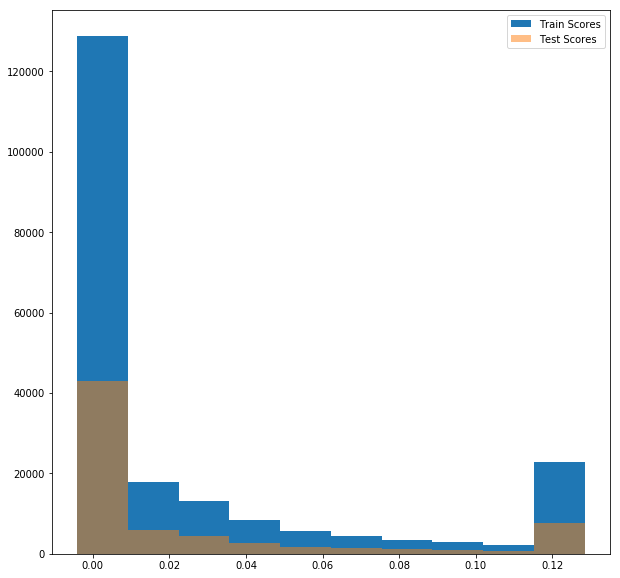

In [12]:
trainY = train['clap_zscore']
testY = test['clap_zscore']

fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))

ax1.hist(trainY, 10, label = 'Train Scores')
ax1.hist(testY, 10, label = 'Test Scores', alpha = 0.5)

ax1.legend()

In [14]:
tokenizer = text.Tokenizer(num_words = maxFeatures)
tokenizer.fit_on_texts(list(listSentencesTrain))

# train data
listTokenizedTrain = tokenizer.texts_to_sequences(listSentencesTrain)
XTrain = sequence.pad_sequences(listTokenizedTrain, maxlen = maxLen)

# test data
listTokenizedTest = tokenizer.texts_to_sequences(listSentencesTest)
XTest = sequence.pad_sequences(listTokenizedTest, maxlen = maxLen)

# CNN Model Building

In [15]:
def buildModel(convLayers = 2, maxDilationRate = 3):
    
    embedSize = 128
    
    inp = Input(shape=(maxLen, ))
    
    x = Embedding(maxFeatures, embedSize)(inp)
    x = Dropout(0.25)(x)
    
    #x = Conv1D(2*embedSize, kernelSize = 3)(x)
    
    prefilt_x = Conv1D(2*embedSize, kernel_size = 3)(x)
    
    out_conv = []
    
    # dilation rate lets us use ngrams and skip grams to process 
    for dilation_rate in range(maxDilationRate):
        x = prefilt_x
        for i in range(3):
            x = Conv1D(32*2**(i), kernel_size = 3, dilation_rate = dilation_rate+1)(x)    
        out_conv += [Dropout(0.5)(GlobalMaxPool1D()(x))]
        
    x = concatenate(out_conv, axis = -1)    
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="tanh")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])

    return model

model = buildModel()
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 128)     3840000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 150, 128)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 148, 256)     98560       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [17]:
batch_size = 32
epochs = 1

file_path="weights.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

callbacks_list = [checkpoint, early] #early
model.fit(XTrain, trainY, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks_list)

Train on 167745 samples, validate on 41937 samples
Epoch 1/1
167745/167745 [==============================] - 1291s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0337 - val_loss: 0.0019 - val_mean_absolute_error: 0.0341

Epoch 00001: val_loss improved from inf to 0.00191, saving model to weights.hdf5


In [18]:
model.load_weights(file_path)
model.save('full_model.h5')

# CNN evaluation and prediction

loss value & metrics values for the model in test mode.

In [24]:
model.evaluate(XTest, testY)

69895/69895 [==============================] - 97s 1ms/step


[0.0018910235921514578, 0.03395009154763137]

In [25]:
test['pred_claps'] = model.predict(XTest) * stdScore + medianScore


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
y_pred = model.predict(XTest) 

In [39]:
y_pred

array([[0.02487026],
       [0.02487026],
       [0.02487026],
       ...,
       [0.02487026],
       [0.02487026],
       [0.02487026]], dtype=float32)